# File and libraries

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

filepath=r'dataset/df_msg_mv_input.csv'

file_tag = "df_msg_outlier_input"

# DSLabs functions

In [13]:
%run "scripts/dslabs_functions.py"

# Data functions

In [14]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [15]:
# test_data=True
test_data=False
if test_data==True:

    data=pd.read_csv(filepath)

    # 1% sample
    data=data.sample(frac=0.01, replace=False)
    
else:
    data=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

target='is_clicked'

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195562 entries, 0 to 195561
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   platform                      195562 non-null  float64
 1   email_provider                195562 non-null  float64
 2   campaign_type                 195562 non-null  float64
 3   channel_cmp                   195562 non-null  float64
 4   topic                         195562 non-null  float64
 5   total_count                   195562 non-null  float64
 6   subject_length                195562 non-null  float64
 7   subject_with_deadline         195562 non-null  float64
 8   subject_with_emoji            195562 non-null  float64
 9   subject_with_bonuses          195562 non-null  float64
 10  subject_with_discount         195562 non-null  float64
 11  subject_with_saleout          195562 non-null  float64
 12  day_of_year                   195562 non-null  fl

In [16]:
data.shape[0]

195562

# Outlier Analysis

- engagement_time_msec is the only numeric column that has outliers that need to be treated
- this is most likely due to idle time by the user when navigating in the page and then clicking on something after some minutes.

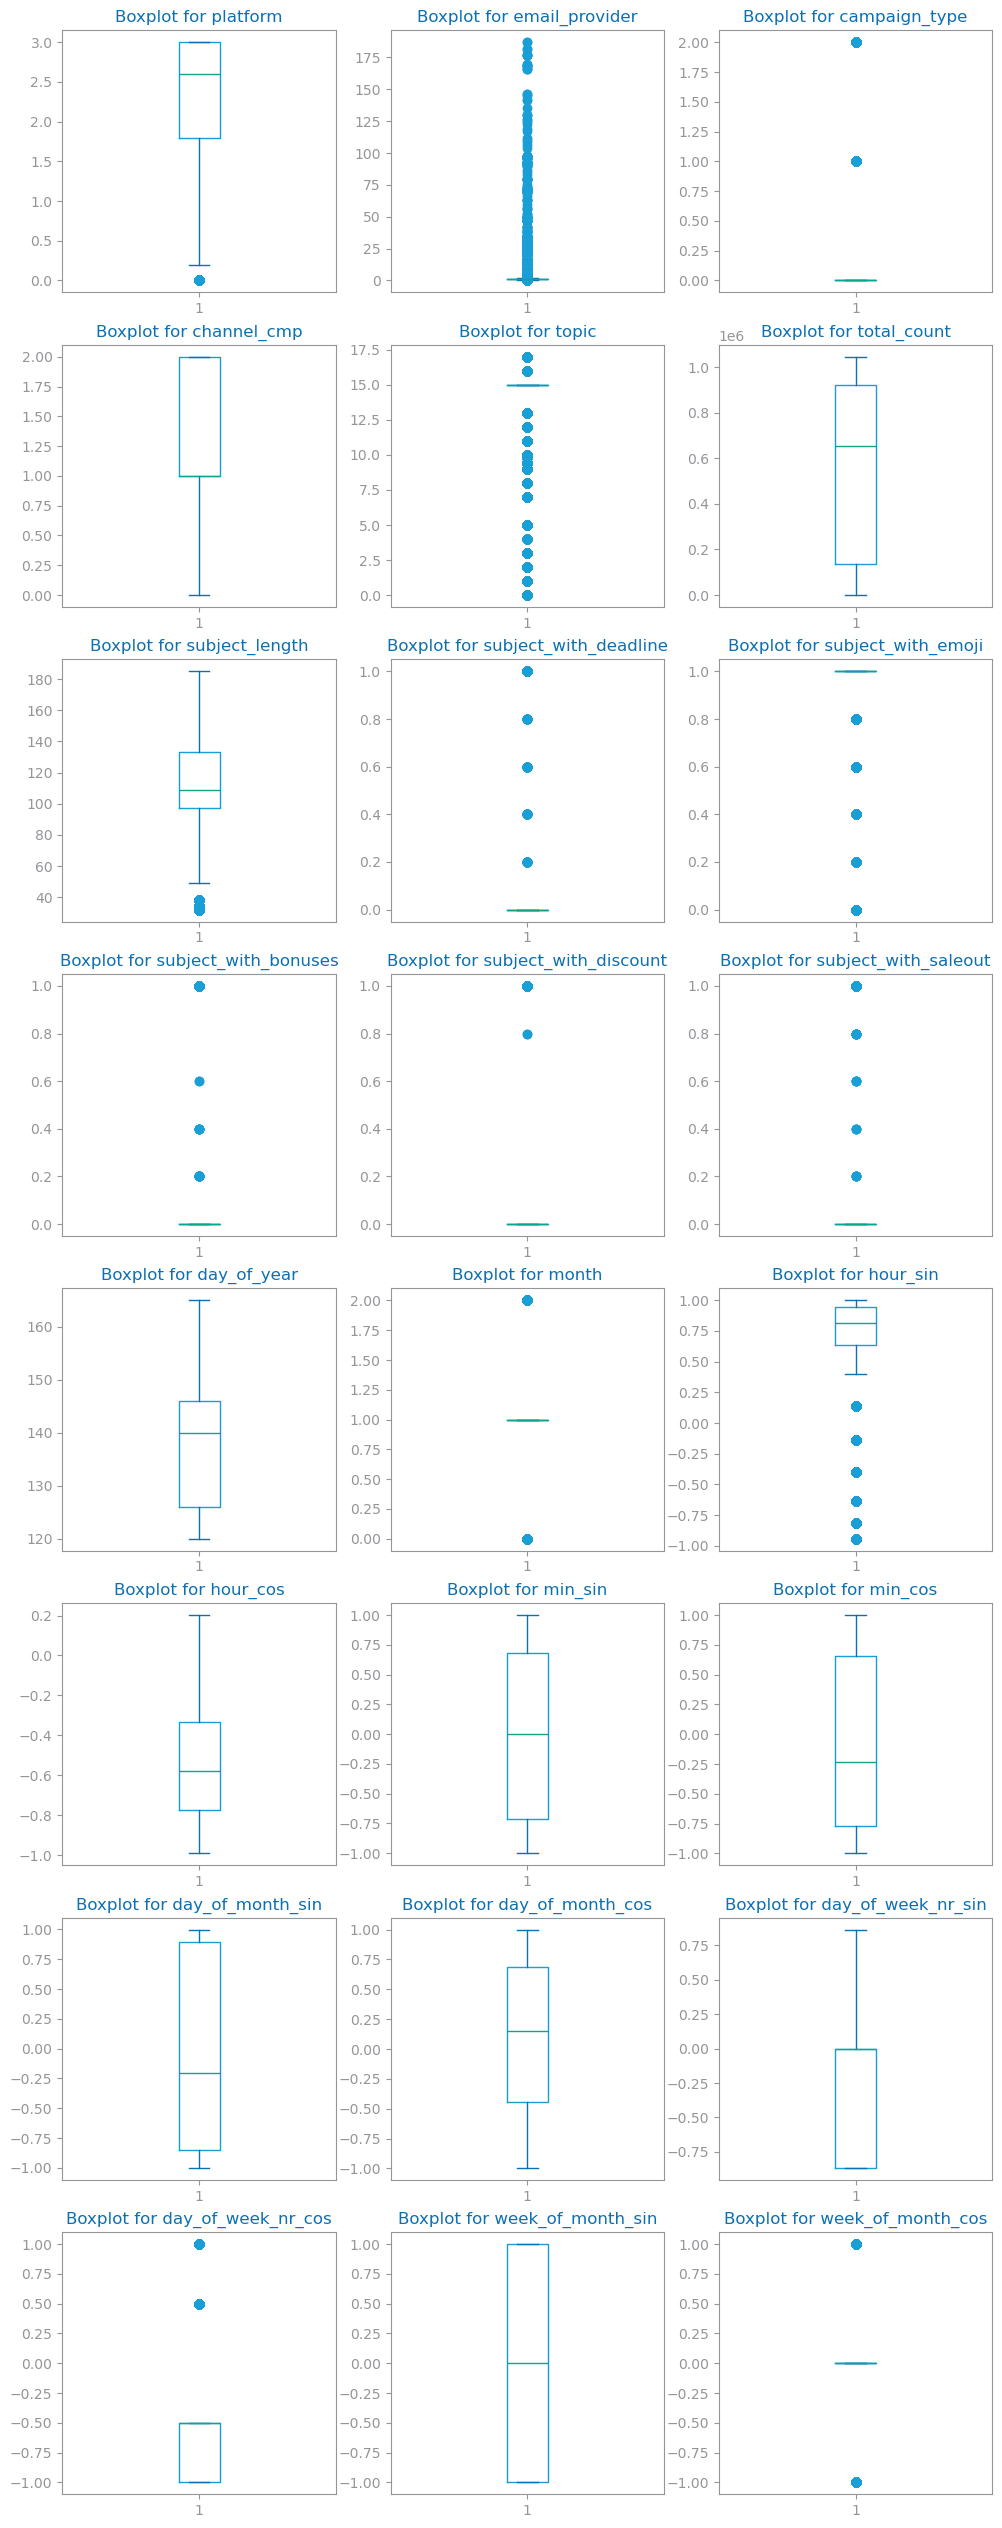

In [17]:

variable_types: dict[str, list] = get_variable_types(data)

numeric: list[str] = variable_types["numeric"]

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"./{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

# Out 1 - Outlier Truncation

## Out 1 strategy aplication
only on variables i saw in data profiling

In [18]:
# List of variables you want to apply the outlier strategy to
variables = ["subject_length", "day_of_week_nr_cos", "hour_sin"]

def apply_strategy_1(df, variables):
    df_copy = df.copy()
    
    for var in variables:
        summary5 = df[[var]].describe(include="all")

        # Determine outlier thresholds for the current variable
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])

        # Apply the truncation strategy to the current variable
        df_copy[var] = df_copy[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )

        print(f"Data after truncating outliers for {var}: {df_copy.shape}")

    return df_copy

data_1 = apply_strategy_1(data, variables)

data_1[variables].describe()

Data after truncating outliers for subject_length: (195562, 28)
Data after truncating outliers for day_of_week_nr_cos: (195562, 28)
Data after truncating outliers for hour_sin: (195562, 28)


,subject_length,day_of_week_nr_cos,hour_sin
count,195562.000000,195562.000000,195562.000000
mean,112.711110,-0.407341,0.668494
std,19.282697,0.626129,0.353231
min,72.610354,-1.000000,-0.243735
25%,97.000000,-1.000000,0.631000
50%,109.000000,-0.500000,0.817000
75%,133.000000,-0.500000,0.942000
max,152.794128,0.907847,0.998000


## Out 1 Target Prep

In [19]:
from numpy import array, ndarray


y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)


Labels=[0.0, 1.0]


## Out 1 train/test split 

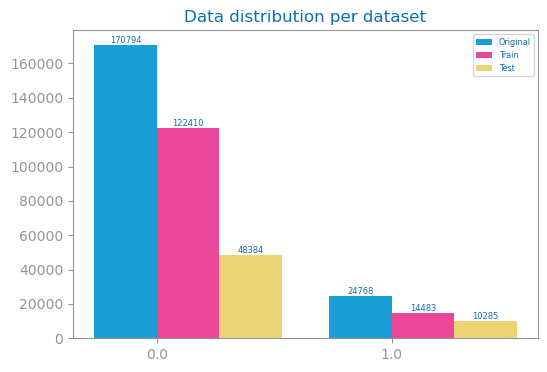

In [20]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Out 1 evaluate

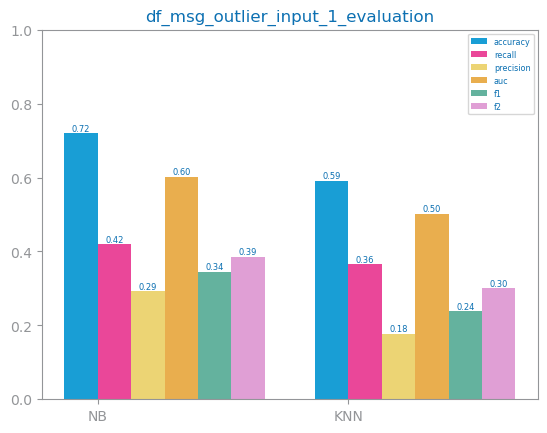

In [21]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_clicked', metric="f2")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_1_evaluation.png")
show()

# Out 2 - drop outlier strategy


## Out 2 strategy aplication

In [ ]:
from pandas import DataFrame, Series

# List of variables you want to apply the outlier strategy to
variables = ["subject_length", "day_of_week_nr_cos", "hour_sin"]


def apply_strategy_2(df, variables):
    df_copy = df.copy()
    
    for var in variables:
        # Calculate the summary statistics for the current variable
        summary5 = df[[var]].describe(include="all")

        # Determine outlier thresholds for the current variable
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])

        # Identify outliers for the current variable
        outliers: DataFrame = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]

        # Drop the outliers from the DataFrame
        df_copy.drop(outliers.index, axis=0, inplace=True)

        print(f"Data after removing outliers for {var}: {df_copy.shape}")

    return df_copy

data_2 = apply_strategy_2(data, variables)

data_2[variables].describe()


Data after removing outliers for subject_length: (193041, 28)
Data after removing outliers for day_of_week_nr_cos: (168410, 28)
Data after removing outliers for hour_sin: (157548, 28)


,subject_length,day_of_week_nr_cos,hour_sin
count,157548.000000,157548.000000,157548.000000
mean,113.269504,-0.621071,0.748163
std,19.167645,0.372677,0.237073
min,74.000000,-1.000000,-0.136000
25%,97.000000,-1.000000,0.631000
50%,112.000000,-0.500000,0.817000
75%,133.000000,-0.500000,0.942000
max,146.000000,0.500000,0.998000


## Out 2 target prep

In [ ]:
y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)


Labels=[0.0, 1.0]


## Out 2 train/test split 

<Axes: title={'center': 'Data distribution per dataset'}>

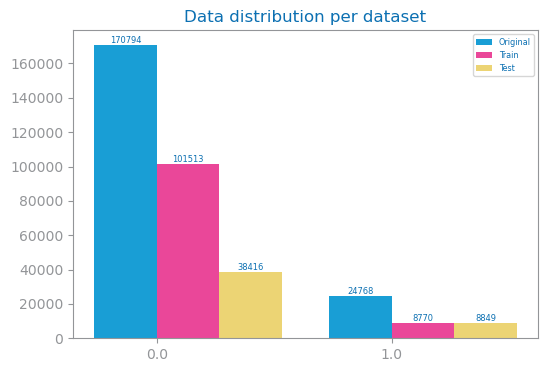

In [ ]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Out 2 evaluate

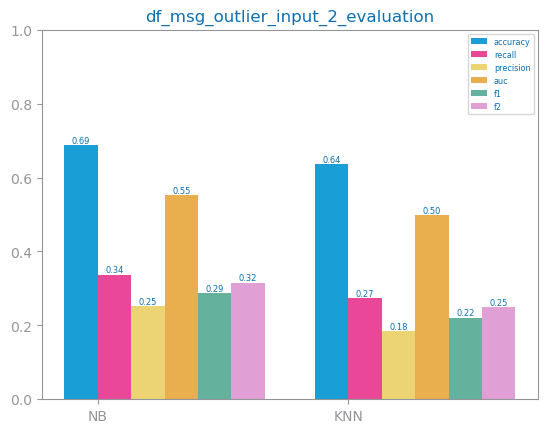

In [ ]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_clicked', metric="f2")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_2_evaluation.png")
show()

# Approach uplift comparison

## uplift df

In [ ]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1

# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])

# Display the DataFrame
comparison_df

Approach 1                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.720721  0.419349  0.292883  0.602066  0.344888  0.386013   
KNN           0.591624  0.364706  0.177134  0.502283  0.238454  0.300966   

            Approach 2                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.687782  0.336761  0.251095  0.552700  0.287686  0.315251   
KNN           0.636729  0.274381  0.184260  0.497288  0.220467  0.249933   

               Uplift                                                    
             accuracy    recall precision       auc        f1        f2  
Naive Bayes -0.032940 -0.082587 -0.041788 -0.049367 -0.057202 -0.070762  
KNN          0.045105 -0.090325  0.007126 -0.004995 -0.017987 -0.051033

# Analysis
- tenho mais precision e overall está melhor

# save to csv

In [ ]:
if test_data==False:
    
    # out1 strategy applied (online truncation)
    data=apply_strategy_1(data, variables)
    
    data.to_csv(f"dataset/df_msg_outlier_input.csv", index=False)

Data after truncating outliers for subject_length: (195562, 28)
Data after truncating outliers for day_of_week_nr_cos: (195562, 28)
Data after truncating outliers for hour_sin: (195562, 28)


In [ ]:
data.shape[0]

195562